## Group Assignment

#### Import the necessary libraries

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from scipy.optimize import minimize
import pandas_datareader.data as web
import matplotlib.pyplot as plt

#### All questions in Parts I and II apply to a random sample of 15 stocks that your group will be assigned by running the following code.

#### Random Sample Selection 

In [16]:
np.random.seed (2051 + 11)
ticker_list = ['AAPL', 'AXP', 'BA', 'C','CAT', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO',
            'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WMT', 'XOM']

stock_list = np.random.choice(ticker_list,15,replace=False)
print(f'These are the fifteen stocks assigned to you: {" ".join(stock_list)}')

These are the fifteen stocks assigned to you: V JNJ CAT CSCO CVX C NKE TRV MCD INTC DIS IBM PFE GS MRK


### PART I

#### 1. Find the optimal portfolio over the period January 2015 - December 2019, using the fifteen stocks assigned to your group. Assume there are no short-selling constraints.

In [43]:
start=dt.datetime(2015,1,1)
end=dt.datetime(2019,12,31)
df=yf.download(list(stock_list),start-pd.offsets.BDay(1),end+pd.offsets.BDay(1))['Adj Close'].pct_change().dropna()
df.head()

[*********************100%***********************]  15 of 15 completed


,C,CAT,CSCO,CVX,DIS,GS,IBM,INTC,JNJ,MCD,MRK,NKE,PFE,TRV,V
Date,,,,,,,,,,,,,,,
2015-01-02,0.002772,0.003824,-0.000724,0.003565,-0.004671,0.002992,0.010097,0.001929,-0.000478,-0.004696,0.007043,-0.011649,0.005779,-0.003874,0.010755
2015-01-05,-0.031515,-0.052786,-0.019920,-0.039971,-0.014613,-0.031223,-0.015735,-0.011276,-0.006984,-0.011045,0.014863,-0.016100,-0.005426,-0.012045,-0.022074
2015-01-06,-0.035204,-0.006435,-0.000370,-0.000463,-0.005304,-0.020229,-0.021566,-0.018637,-0.004914,0.001843,0.039283,-0.005882,0.008344,-0.008928,-0.006444
2015-01-07,0.009270,0.015497,0.009242,-0.000833,0.010230,0.014903,-0.006535,0.020975,0.022076,0.017424,0.021386,0.020656,0.013686,0.017048,0.013398
2015-01-08,0.015048,0.010249,0.007692,0.022883,0.010341,0.015966,0.021735,0.018601,0.007863,0.003723,0.020127,0.023084,0.020408,0.020762,0.013413


In [44]:
df = df.resample(rule = 'M').apply(lambda x: x.add(1).prod().sub(1))
df.tail()

,C,CAT,CSCO,CVX,DIS,GS,IBM,INTC,JNJ,MCD,MRK,NKE,PFE,TRV,V
Date,,,,,,,,,,,,,,,
2019-08-31,-0.088902,-0.096225,-0.155054,-0.033952,-0.040207,-0.067870,-0.074967,-0.055784,-0.006897,0.039876,0.041933,-0.015247,-0.076144,0.002319,0.017308
2019-09-30,0.073504,0.061428,0.055544,0.007475,-0.050561,0.016282,0.072973,0.086902,0.007947,-0.014956,-0.020014,0.111480,0.010689,0.017229,-0.048723
2019-10-31,0.040243,0.099542,-0.031171,-0.020742,-0.003069,0.029677,-0.080388,0.097031,0.020559,-0.083881,0.029461,-0.046529,0.067910,-0.118569,0.039823
2019-11-30,0.052838,0.050290,-0.046306,0.018462,0.166718,0.043200,0.017259,0.032540,0.048490,-0.004950,0.006000,0.046722,0.013611,0.043186,0.033317
2019-12-31,0.063498,0.020383,0.058486,0.028857,-0.040134,0.038762,-0.003050,0.031008,0.060950,0.016094,0.050398,0.083645,0.017134,0.007771,0.018373


In [45]:
rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)

rf.index = rf.index.to_timestamp(how='end').normalize()

rf.tail()

,RF
Date,
2019-08-31,0.0016
2019-09-30,0.0018
2019-10-31,0.0016
2019-11-30,0.0012
2019-12-31,0.0014


In [46]:
df = df[df.index<=rf.index[-1]]

In [47]:
# Define the portfolio returns function
def port_ret(weights):
    port_ret = np.dot(df*12,weights).mean()
    return port_ret

# Define the portfolio standard deviation function
def port_std(weights):
    port_std = np.sqrt(np.dot(weights, np.dot(df.cov()*12, weights)))
    return port_std

# Define the excess portfolio returns function
def ex_port_ret(weights):
    ex_port_ret = (np.dot(df,weights) - rf['RF']).mean()*12
    return ex_port_ret

# Define the excess portfolio standard deviation function
def ex_port_std(weights):
    ex_port_std = (np.dot(df,weights) - rf['RF']).std()*np.sqrt(12)
    return ex_port_std

# Define the negative Sharpe Ratio function that we will minimize
def neg_SR(weights):
    SR = ex_port_ret(weights) / ex_port_std(weights)
    return (-1)*SR

In [48]:
# setting up constraints
constraints = ({'type':'eq','fun': lambda weights: np.sum(weights) - 1})

# equally weighted first guess
init_guess = np.full(len(df.columns), 1/len(df.columns))

In [49]:
# creating the optimal portfolio
optimal_port = minimize(neg_SR,init_guess,constraints=constraints)
optimal_port

     fun: -2.021367033373226
     jac: array([-0.07702711, -0.07684243, -0.07683203, -0.0772208 , -0.07583207,
       -0.07734382, -0.07695726, -0.07688063, -0.07660535, -0.07636908,
       -0.07693163, -0.07695597, -0.07753477, -0.07631686, -0.07711744])
 message: 'Optimization terminated successfully'
    nfev: 233
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([-0.12048765,  0.12277952, -0.02767407, -0.256125  , -0.02935396,
        0.10965568, -0.10605186,  0.12656446, -0.07922199,  0.60432083,
        0.17241865,  0.30115424,  0.06801947, -0.30607049,  0.42007217])

#### 2. What are the weights of the stocks in the optimal portfolio?

In [50]:
# weights of portfolio
for tic in stock_list:
    print(tic + "  "+ str(round(optimal_port.x[list(stock_list).index(tic)],4)),end="  ")

V  -0.1205  JNJ  0.1228  CAT  -0.0277  CSCO  -0.2561  CVX  -0.0294  C  0.1097  NKE  -0.1061  TRV  0.1266  MCD  -0.0792  INTC  0.6043  DIS  0.1724  IBM  0.3012  PFE  0.068  GS  -0.3061  MRK  0.4201  

#### 3. What was the annualized average monthly return for the optimal portfolio?

In [51]:
# portfolio return
port_ret(optimal_port.x)

0.262890325175225

#### 4. What was the annualized monthly standard deviation for the optimal portfolio?

In [52]:
# std of portfolio
port_std(optimal_port.x)

0.12531917607879195

#### 5. What was the Sharpe Ratio of the optimal portfolio?

In [54]:
# sharpe ratio
-optimal_port.fun

2.021367033373226

### PART II

#### 1. Create a DataFrame named optimal_weights to store the weights from a portfolio optimization performed on a rolling basis. Specifically, the optimization should use a 60 month rolling window, and be performed every month. The first 60 months correspond to the sample period for data_initial (01/2015 - 12/2019) created in question 3. Hence, the first observation in the optimal_weights DataFrame should be the weights you listed above in Part I. The next 60 month period should be 02/2015 - 01/2020, followed by 03/2015 - 02/2020, and so on. The last 60 month period should be 03/2018 - 02/2023. Again, assume there are no short-selling constraints.

#### 2. Create a new DataFrame named port_returns to store the monthly returns over the sample period 01/2020 - 02/2023 for the following portfolios:
 1) A monthly rebalanced portfolio using the rolling optimal weights. Specifically, the portfolio return for 01/2020 should be based on the weights as of 12/2019 (the same values detailed in Part I and in the first row in the optimal_weights DataFrame), the portfolio return for 02/2020 should be based on the weights as of 01/2020 and so on. Label the portfolio (MRoll_Reb_OP, an acronym for Monthly Rolling Rebalanced Optimal Portfolio). 
 2) A monthly rebalanced portfolio using the optimal weights as of 12/2019. Label the portfolio (M_Reb_OP, an acronym for Monthly Rebalancing Optimal Portfolio).
 3) A monthly rebalanced equally-weighted portfolio. Label the portfolio (M_Reb_EW, an acronym for Monthly Rebalancing Equally-Weighted Portfolio).
 4) A buy and hold portfolio, initially allocated according to the optimal weights as of 12/2019. Label the portfolio (BH_OP, an acronym for Buy and Hold Optimal Portfolio).
 5) A buy and hold portfolio, initially allocated equally across stocks. Label the portfolio (BH_EW, an acronym for Buy and Hold Equally-Weighted Portfolio).

#### 3. Create a DataFrame port_stats (with a 3x5 shape) to store the annualized average monthly return, the annualized monthly standard deviation and the Sharpe ratio for all 5 portfolios.

#### 4. Compute the cumulative return series for all portfolios and plot them in the same graph. 

#### 5. What was the cumulative return for the best performing portfolio? What was the cumulative return for the worst performing portfolio?

### PART III - Examination of the Size Effect

Please download the file "crsp_fall22.csv" located in folder Group_Assignment. The file contains the following columns:
* PERMNO - Permanent number (unique identifer for the stock)
* DATE
* PRC - The closing price
* VOL - Trading volume (in hundreds)
* RET - The simple return
* SHROUT - The number of shares outstanding (in thousands)
* CFACPR - Cumulative factor to adjust the closing price
* CFACSHR - Cumulative factor to adjust shares outstanding

#### 1. Create a DataFrame named fin_data by reading in the columns DATE, PERMNO, RET, PRC and SHROUT from the file 'crsp_fall22.csv'. Set the DATE as the index. In addition, change each index value to the end of the month. For example, change '1926-05-30' to 1926-05-31', or '1987-01-30' to '1987-01-31'. In addition, create a new column (labeled MKTCAP) to store the market capitalization (defined as PRC * SHROUT). Subsequently, permanently remove the PRC and SHROUT columns.

In [109]:
fin_data = pd.read_csv('crsp_fall22.csv', dtype={'PERMNO':np.int64},
                       usecols=['DATE', 'PERMNO', 'RET', 'PRC', 'SHROUT'])

# convert date col and make the end of the month the index
fin_data['DATE'] = pd.to_datetime(fin_data['DATE'], format='%Y-%m-%d')
fin_data.set_index('DATE', inplace=True)
fin_data.index = fin_data.index + pd.offsets.MonthEnd(0)

# create the MKTCAP column
fin_data['MKTCAP'] = fin_data['PRC'] * fin_data['SHROUT']

# drop cols
fin_data.drop(columns=['PRC', 'SHROUT'], inplace=True)

In [110]:
fin_data

,PERMNO,RET,MKTCAP
DATE,,,
1990-01-31,21573,-0.106195,5.499450e+06
1990-01-31,55160,-0.190476,2.067094e+03
1990-01-31,45129,-0.086420,1.892550e+05
1990-01-31,22250,-0.174684,3.117920e+05
1990-01-31,60468,-0.071429,2.227225e+04
...,...,...,...
2022-03-31,16400,-0.070234,2.676084e+05
2022-03-31,16401,0.424749,9.943693e+04
2022-03-31,90664,0.236017,4.965897e+07


#### 2. How many stocks are there in the sample? How many of these stocks are in the sample over the entire sample period?

In [111]:
num_stocks = fin_data['PERMNO'].nunique()
print(f"The number of stocks in the sample is: {num_stocks}")

num_entire_stocks = fin_data.groupby('PERMNO').size().value_counts().loc[fin_data.index.nunique()]
print(f"The number of stocks in the sample over the entire sample period is: {num_entire_stocks}")

The number of stocks in the sample is: 18153
The number of stocks in the sample over the entire sample period is: 697


#### 3. Every June, split the stocks into quintiles (five groups) based on their market capitalization. The header of a DataFrame named size_qt with the resulting split can be found below. 

In [112]:
split_qt = fin_data.copy()
# splitting into quintiles based off market cap

split_qt['MKTCAP_QT'] = split_qt.groupby(pd.Grouper(freq='A-JUN'))['MKTCAP'].apply(lambda x: pd.qcut(x, 5, labels=False) + 1)

size_qt = split_qt.reset_index()[['PERMNO', 'MKTCAP_QT', 'DATE']]

# filter for only june
size_qt = size_qt[size_qt['DATE'].dt.month == 6]
size_qt = size_qt.set_index('DATE').sort_index()

# offsetting to hit july
size_qt.index = size_qt.index + pd.offsets.MonthEnd()

In [113]:
size_qt.sort_index().head()

,PERMNO,MKTCAP_QT
DATE,,
1990-07-31,10294,3
1990-07-31,65496,3
1990-07-31,10905,2
1990-07-31,32037,1
1990-07-31,66288,5


#### 4. Create a new DataFrame named data by using the merge_asof() function to merge the DataFrames fin_data and size_qt. Specifically, merge each stock's June quintile allocation with the stock's monthly returns for the next 12 months starting the following July. Subsequently, set DATE as the index in the DataFrame.

In [114]:
data = pd.merge_asof(fin_data, size_qt, 
                            on='DATE',
                            by='PERMNO', direction='backward')

data.set_index('DATE', inplace=True)

# dropping first 6 months
data.dropna(inplace=True)

#### 5. Create a new DataFrame called quintiles to store the average monthly return for each quintile. The header of the DataFrame can be found below:

In [115]:
# taking the mean and unstacking the quantiles
quintiles = data.groupby(['DATE', 'MKTCAP_QT'])['RET'].mean().unstack()
quintiles.columns = ['Q1_RET', 'Q2_RET', 'Q3_RET', 'Q4_RET', 'Q5_RET']

In [116]:
quintiles.head()

,Q1_RET,Q2_RET,Q3_RET,Q4_RET,Q5_RET
DATE,,,,,
1990-07-31,-0.001239,-0.043007,-0.041412,-0.041637,-0.028809
1990-08-31,-0.087260,-0.111380,-0.133862,-0.134542,-0.111322
1990-09-30,-0.044903,-0.091021,-0.092244,-0.098746,-0.081242
1990-10-31,-0.069386,-0.064657,-0.071607,-0.060954,-0.039792
1990-11-30,-0.011271,0.002051,0.027951,0.069232,0.100039


#### 6. Create a bar plot of the average monthly return for all five market capitalization groups, across the entire sample.

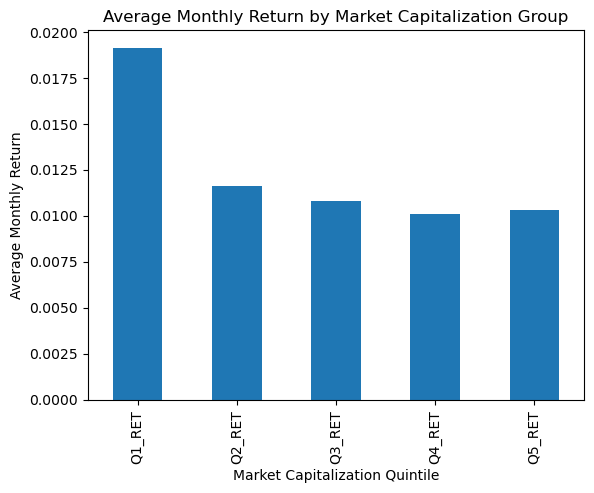

In [117]:
quintiles.mean().plot(kind='bar')

# plotting basics
plt.title('Average Monthly Return by Market Capitalization Group')
plt.xlabel('Market Capitalization Quintile')
plt.ylabel('Average Monthly Return')
plt.show()

#### 7. Create a line plot of the cumulative return series for all five market capitalization groups.

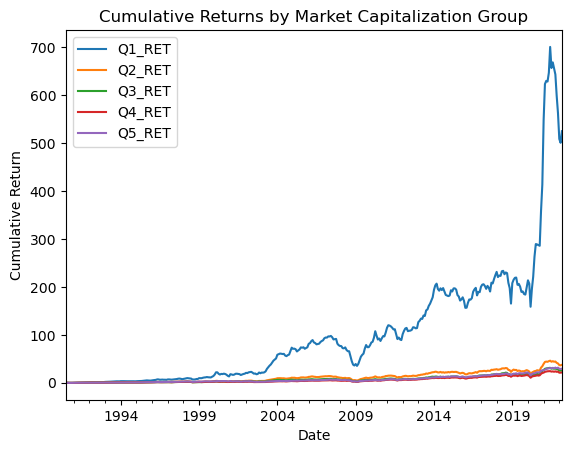

In [118]:
cumulative_returns = (1 + quintiles).cumprod() - 1

# plot cumulative returns
cumulative_returns.plot(kind='line')

plt.title('Cumulative Returns by Market Capitalization Group')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()